In [3]:
!pip install mlflow

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import mlflow
import mlflow.sklearn

In [5]:
import pandas as pd

# Replace 'heart.csv' with the actual filename if different
df = pd.read_csv('data.csv')

print(df.head())
print(df.info())
print(df.isnull().sum())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

    ca  thal  num  
0  0.0   6.0    0  
1  3.0   3.0    2  
2  2.0   7.0    1  
3  0.0   3.0    0  
4  0.0   3.0    0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       

## 3. Basic Info & Missing Values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB
None

Missing values per column:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num

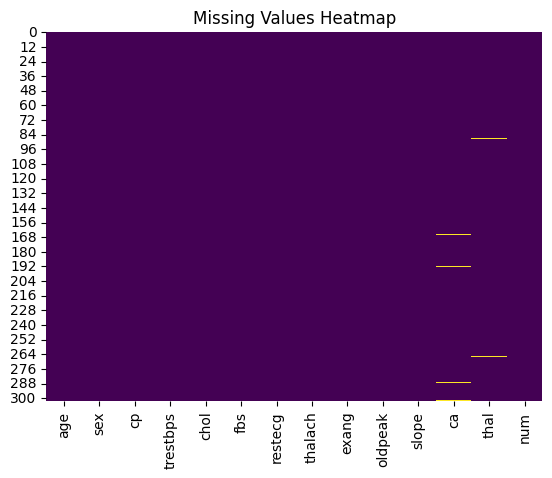

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
print(df.info())
print("\nMissing values per column:\n", df.isnull().sum())

sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

## Univariate Analysis

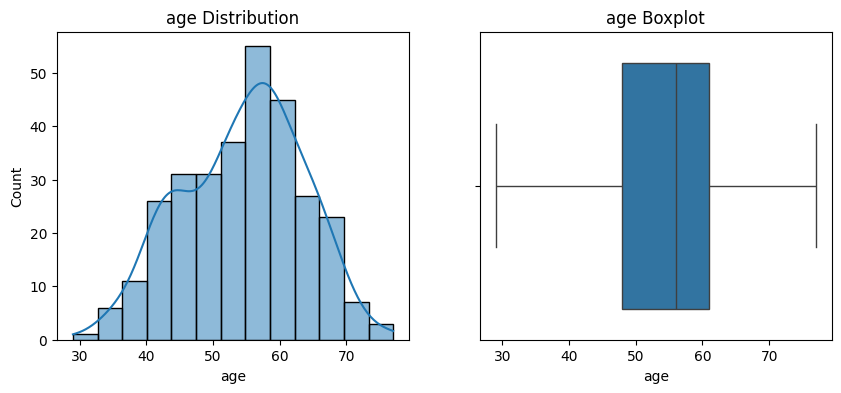

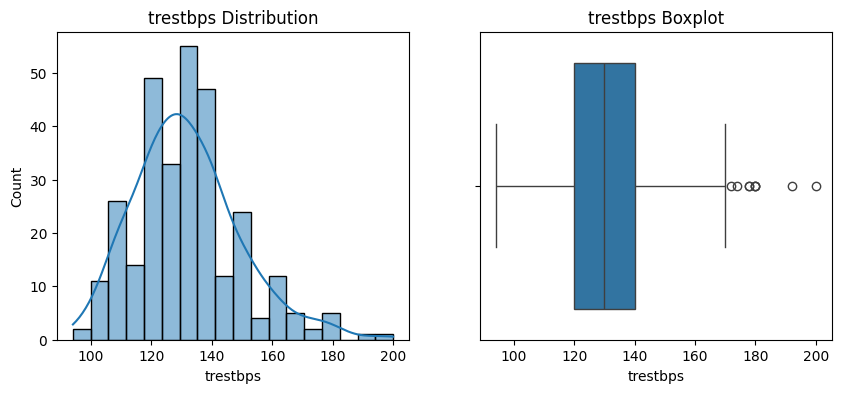

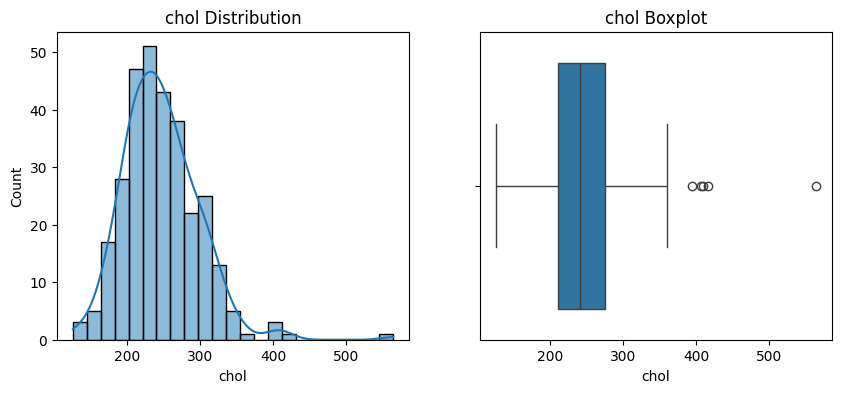

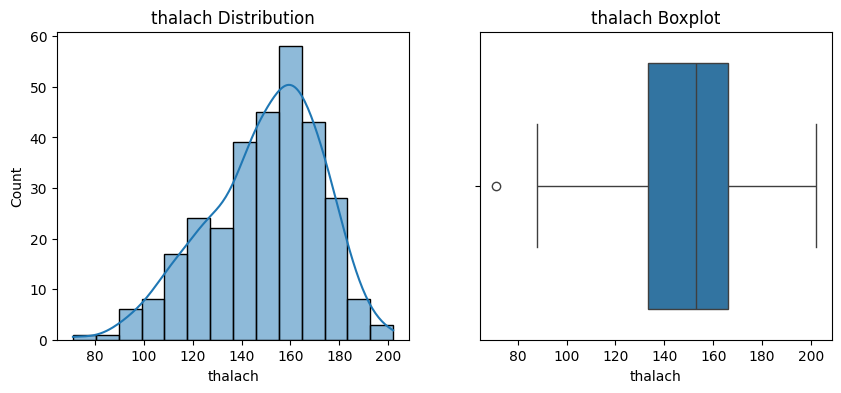

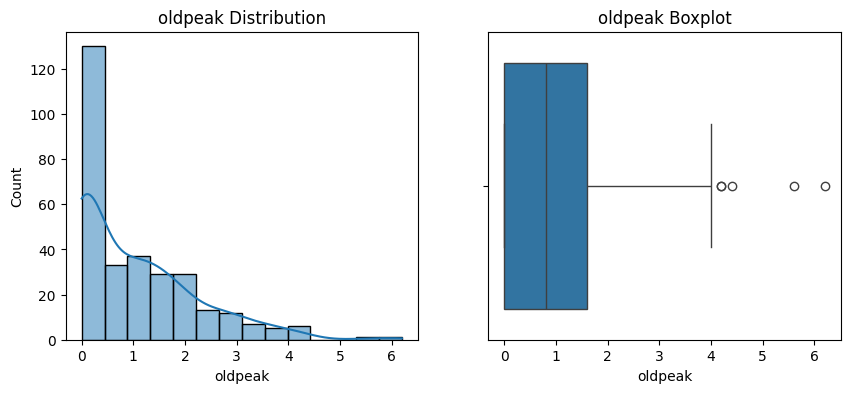

In [7]:
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
for col in numerical_cols:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'{col} Distribution')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col])
    plt.title(f'{col} Boxplot')
    plt.show()

## Categorical Features

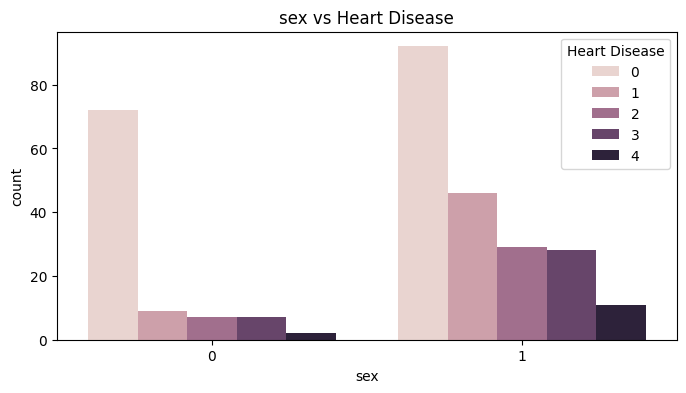

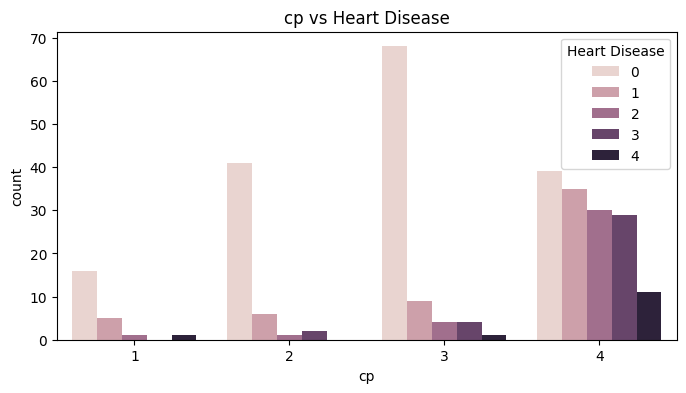

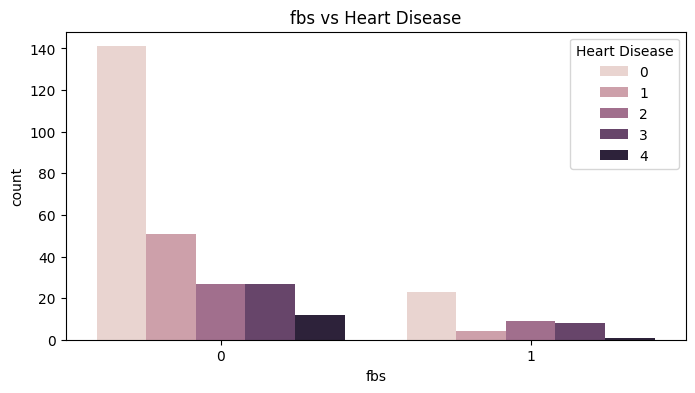

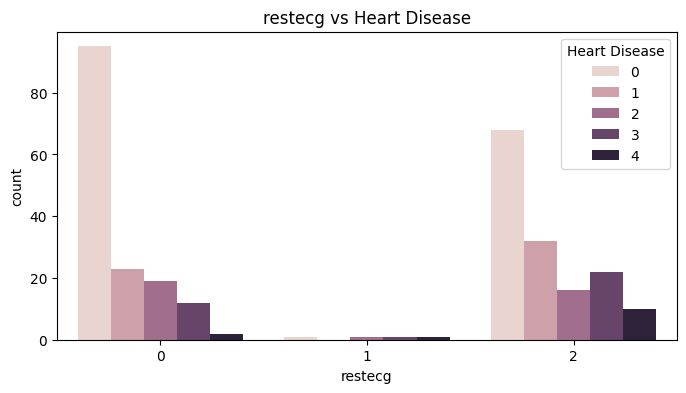

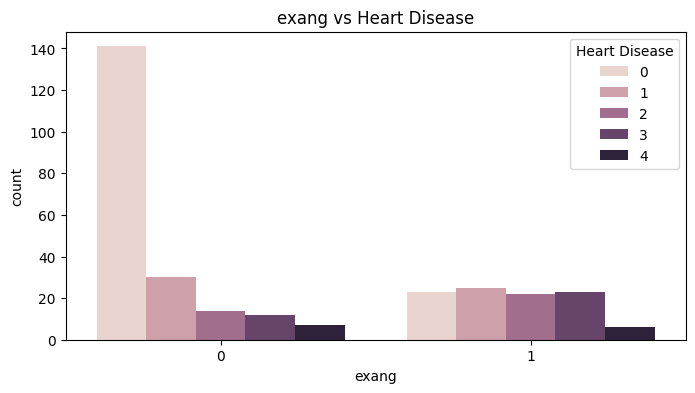

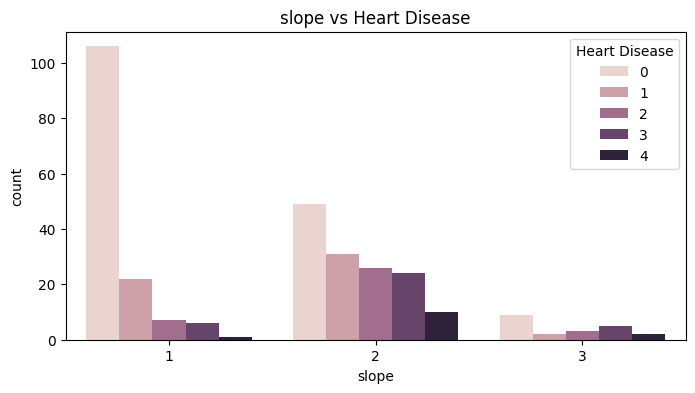

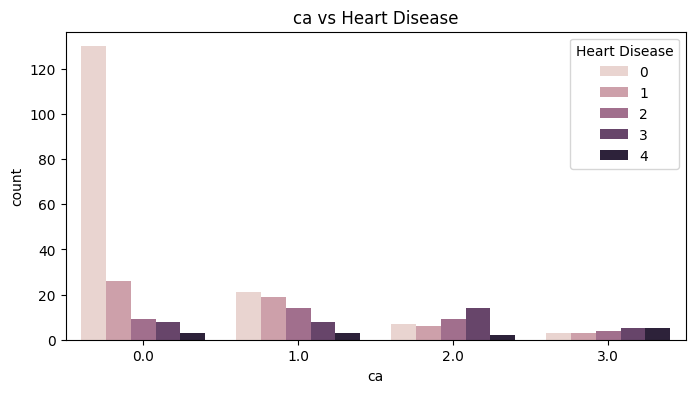

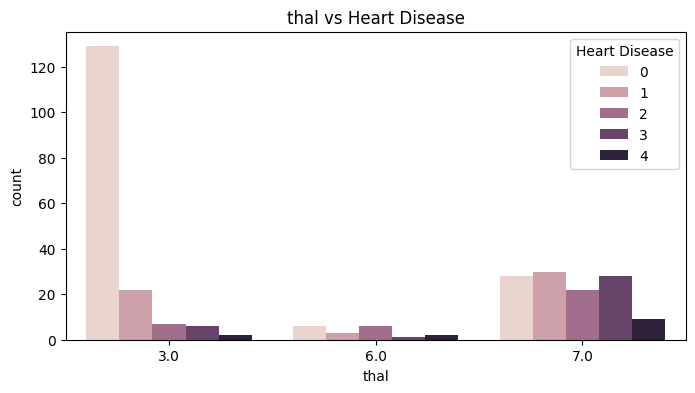

In [8]:
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

df.rename(columns={'num': 'target'}, inplace=True)

for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, hue='target')
    plt.title(f"{col} vs Heart Disease")
    plt.legend(title="Heart Disease")
    plt.show()

## Bivariate Analysis

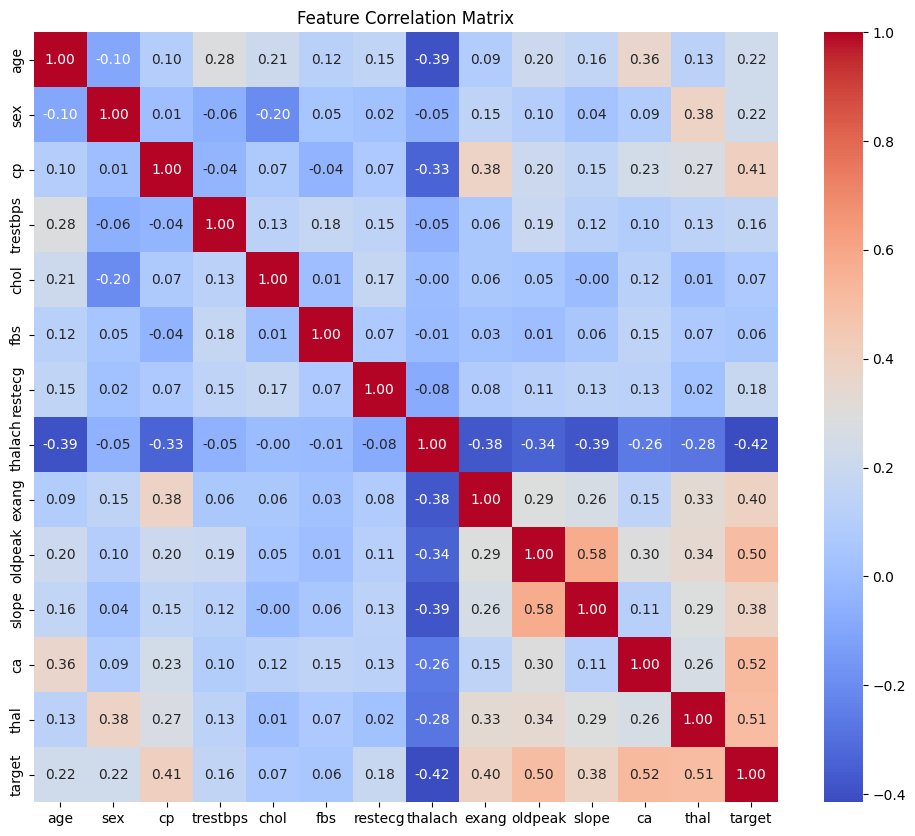

In [9]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Matrix")
plt.show()

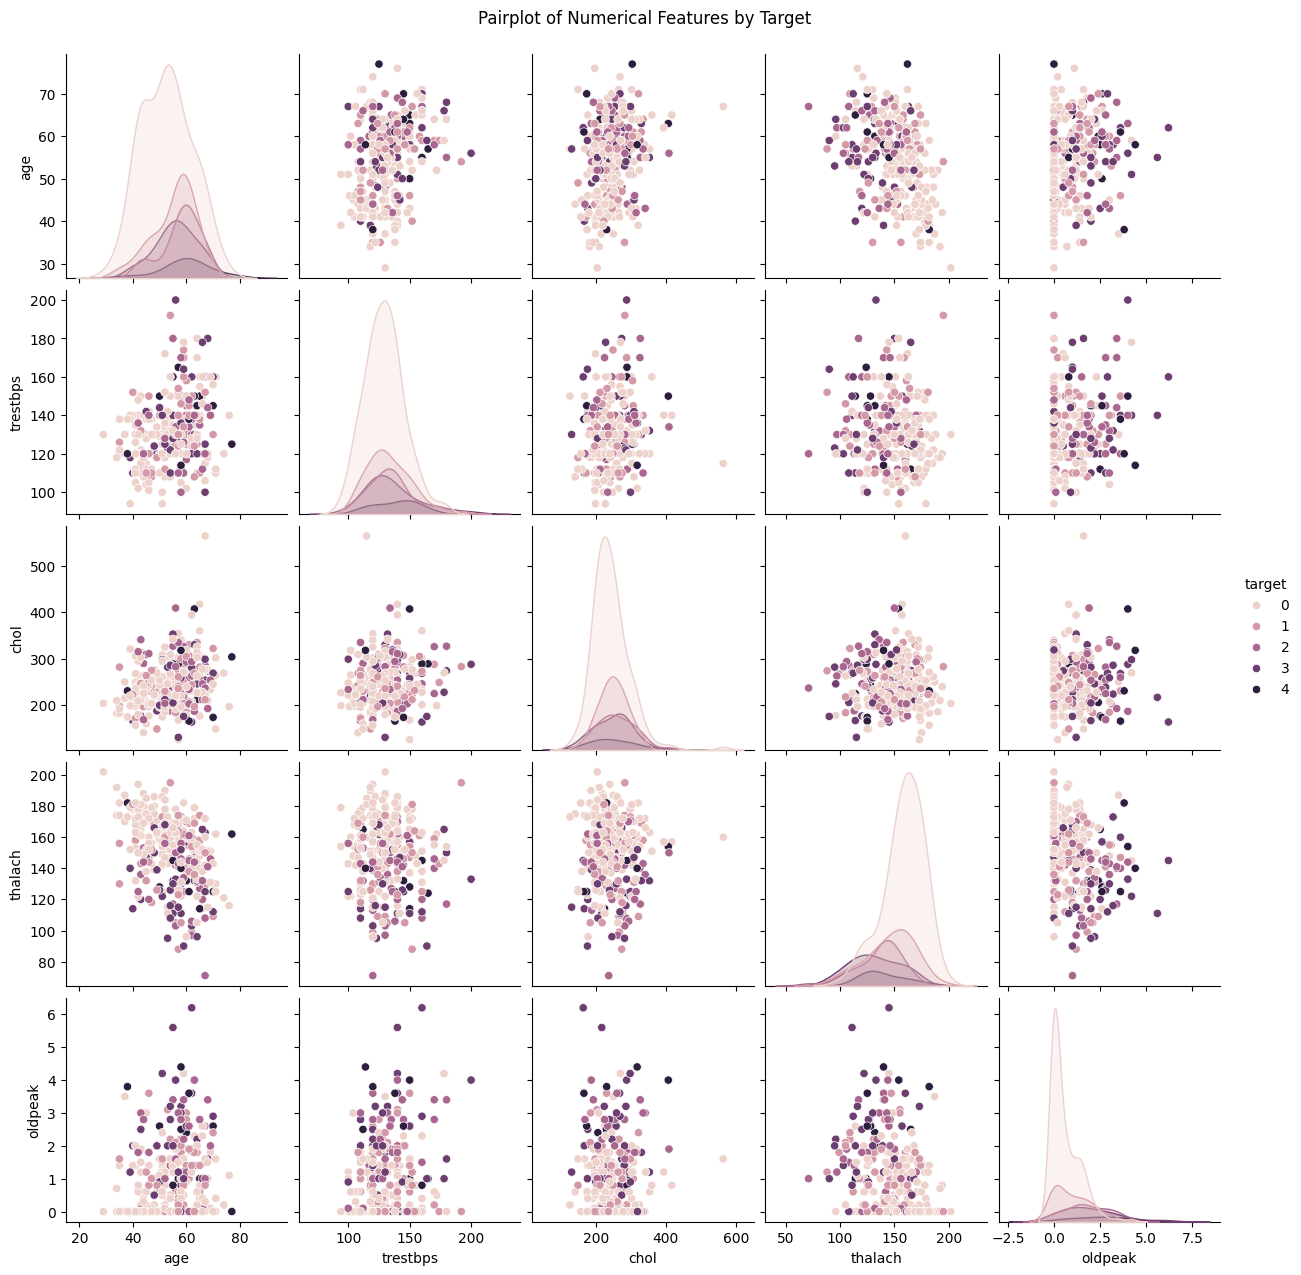

In [10]:
#pair plot of key numerical features
sns.pairplot(data=df, vars=['age', 'trestbps', 'chol', 'thalach', 'oldpeak'], hue='target')
plt.suptitle("Pairplot of Numerical Features by Target", y=1.02)
plt.show()

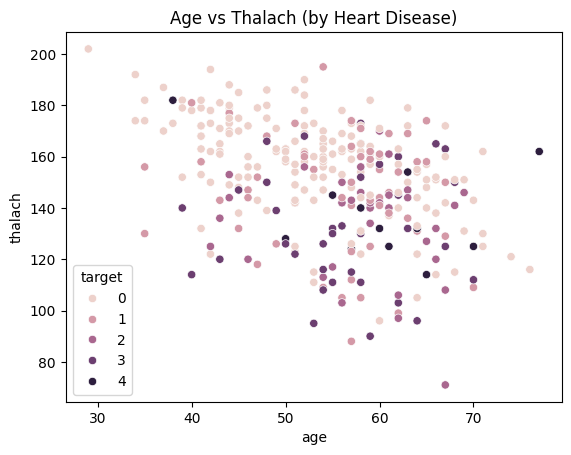

In [11]:
# Age vs Maximum Heart Rate (thalach) – Scatter Plot
sns.scatterplot(data=df, x='age', y='thalach', hue='target')
plt.title("Age vs Thalach (by Heart Disease)")
plt.show()

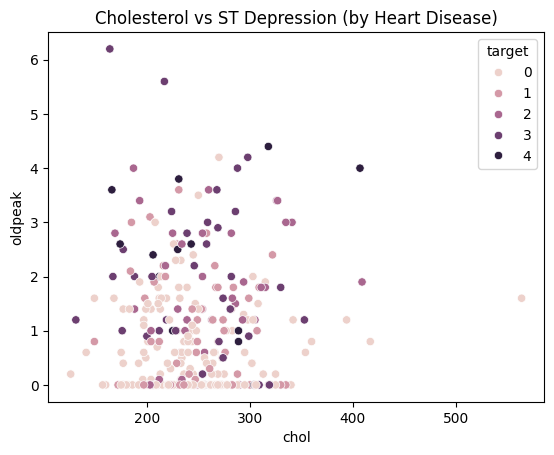

In [12]:
# Cholesterol (chol) vs ST Depression (oldpeak)
sns.scatterplot(data=df, x='chol', y='oldpeak', hue='target')
plt.title("Cholesterol vs ST Depression (by Heart Disease)")
plt.show()


## Multivariate Analysis

Heatmap of Correlation Between Top Predictive Features

rom the paper: slope_1, exang_1, cp, and oldpeak are key variables.

one-hot encoding some categorical features first:

In [13]:
df_encoded = pd.get_dummies(df, columns=['cp', 'slope', 'restecg', 'thal'])

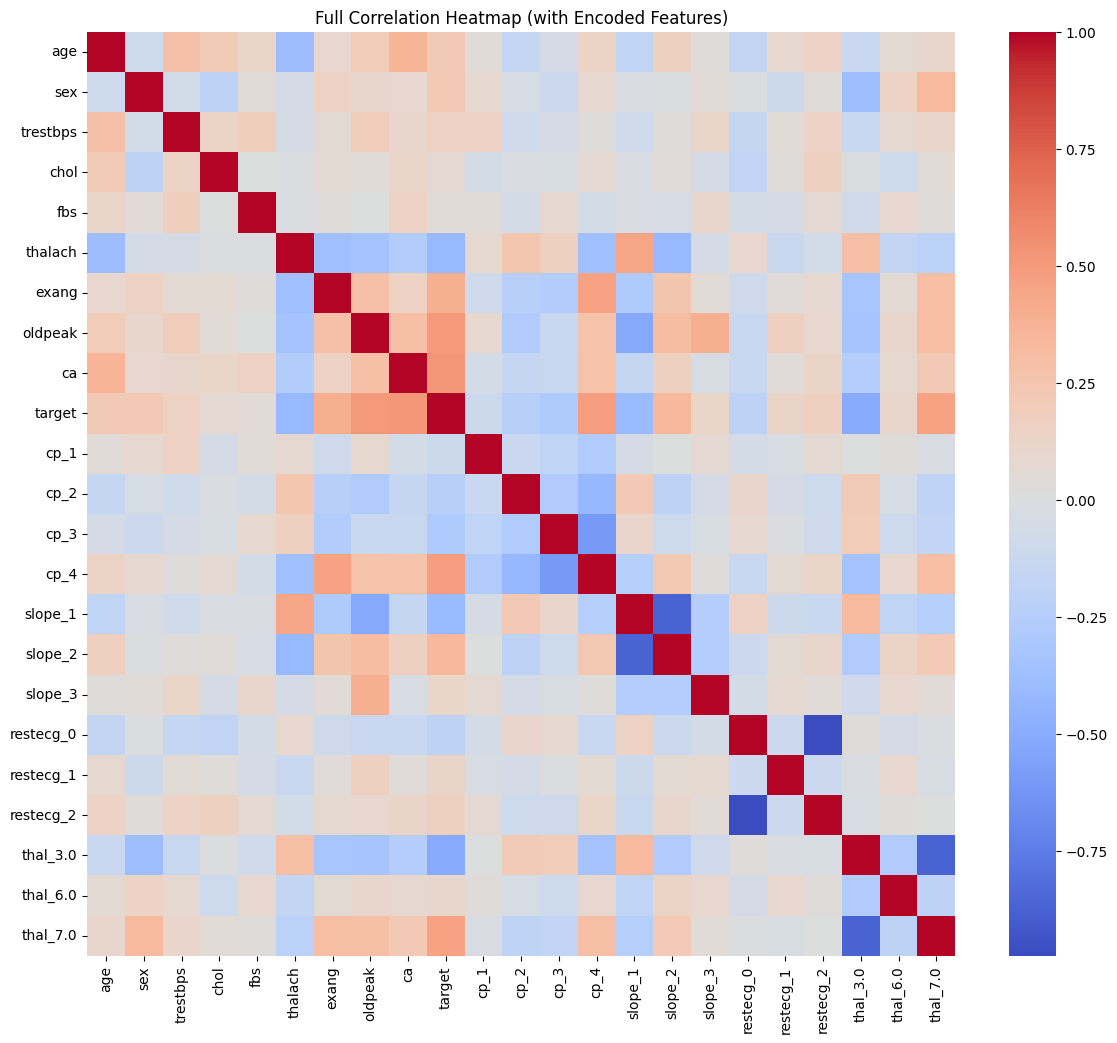

In [14]:
plt.figure(figsize=(14, 12))
corr = df_encoded.corr()
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Full Correlation Heatmap (with Encoded Features)")
plt.show()

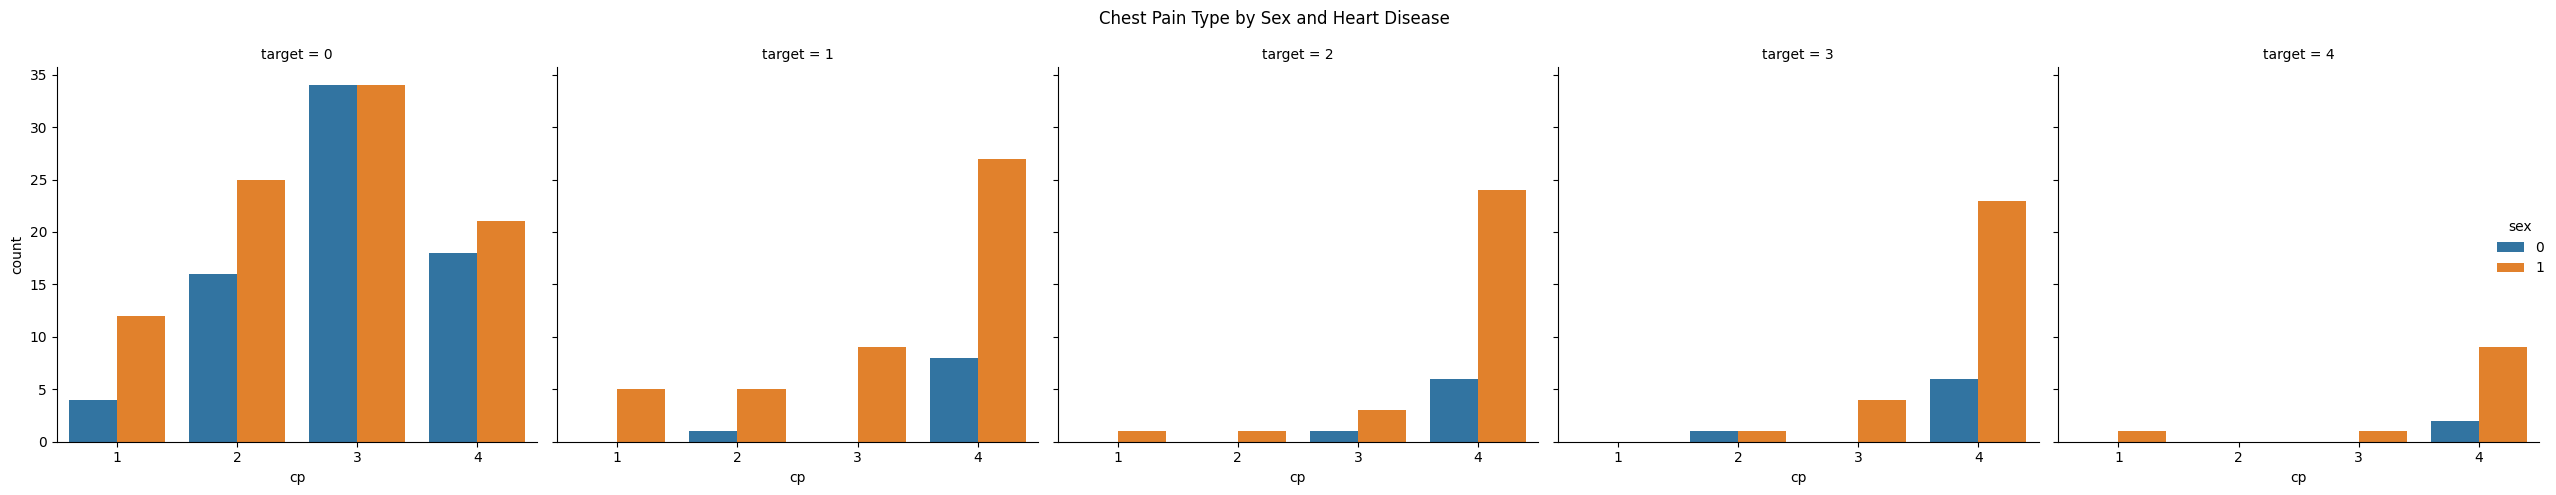

In [15]:
# Grouped Barplots
sns.catplot(x='cp', hue='sex', col='target', kind='count', data=df)
plt.suptitle("Chest Pain Type by Sex and Heart Disease")
plt.tight_layout()
plt.show()

Exercise Induced Angina (exang) vs ST Slope (slope) vs Heart Disease

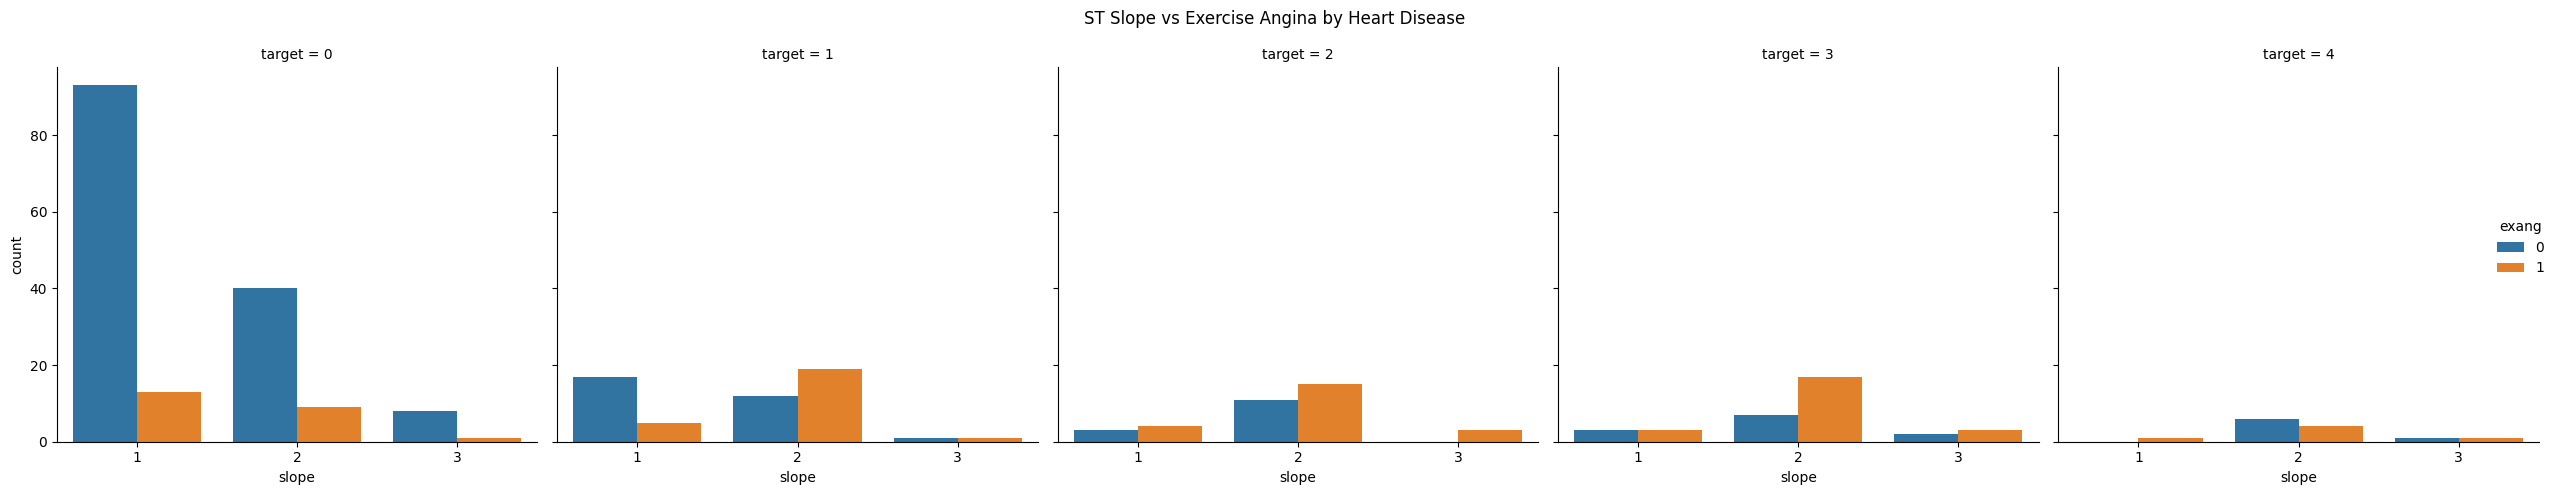

In [16]:
sns.catplot(x='slope', hue='exang', col='target', kind='count', data=df)
plt.suptitle("ST Slope vs Exercise Angina by Heart Disease")
plt.tight_layout()
plt.show()

# Average Derivative (AD) Feature Extraction

The paper mentions creating new features using the Average Derivative method . Let's apply it to numerical columns:

In [17]:
import numpy as np
import pandas as pd

# Sample numerical columns
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

def average_derivative(x):
    return np.gradient(x).mean()

# Create new features based on Average Derivative
new_features = {}
for col in numerical_cols:
    # Compute gradient across the entire column
    new_features[f"AD_{col}"] = [average_derivative(df[col])] * len(df)

# Convert to DataFrame
df_ad = pd.DataFrame(new_features)

# Concatenate with original DataFrame
df = pd.concat([df.reset_index(drop=True), df_ad], axis=1)

print(df.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

    ca  thal  target    AD_age  AD_trestbps  AD_chol  AD_thalach  AD_oldpeak  
0  0.0   6.0       0 -0.107261     0.014851 -0.20462     0.00495   -0.008911  
1  3.0   3.0       2 -0.107261     0.014851 -0.20462     0.00495   -0.008911  
2  2.0   7.0       1 -0.107261     0.014851 -0.20462     0.00495   -0.008911  
3  0.0   3.0       0 -0.107261     0.014851 -0.20462     0.00495   -0.008911  
4  0.0   3.0       0 -0.107261     0.014851 -0.20462     0.00495   -0.008911  


#Polynomial Feature Extraction

Add polynomial combinations of key features:

In [18]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[numerical_cols])
poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(numerical_cols))
df = pd.concat([df.reset_index(drop=True), poly_df.add_prefix('poly_')], axis=1)

# Class Imbalance & Balancing Techniques

Check class imbalance:

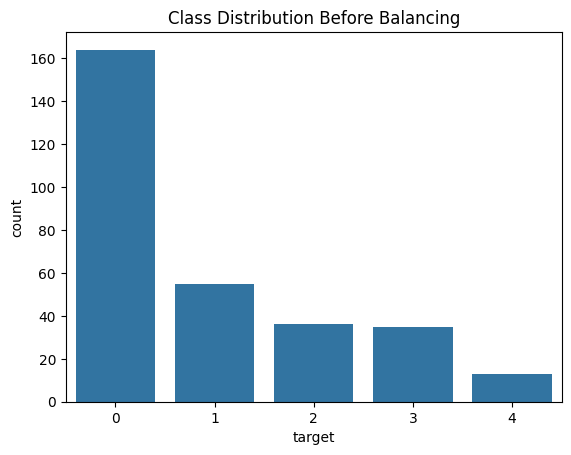

In [19]:
sns.countplot(data=df, x='target')
plt.title("Class Distribution Before Balancing")
plt.show()

In [20]:
# Replace '?' with NaN
df.replace('?', np.nan, inplace=True)

# Convert relevant columns to numeric
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with any missing values
df.dropna(inplace=True)

# Reset index after dropping
df.reset_index(drop=True, inplace=True)

# Apply balancing techniques mentioned in the paper:


SMOTEEN,
ROS,
ADASYN

In [21]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import ADASYN, RandomOverSampler

X = df.drop('target', axis=1)
y = df['target']

smoteenn = SMOTEENN(random_state=42)
ros = RandomOverSampler(random_state=42)
adasyn = ADASYN(random_state=42)

X_res_smoteenn, y_res_smoteenn = smoteenn.fit_resample(X, y)
X_res_ros, y_res_ros = ros.fit_resample(X, y)
X_res_adasyn, y_res_adasyn = adasyn.fit_resample(X, y)

After balancing:

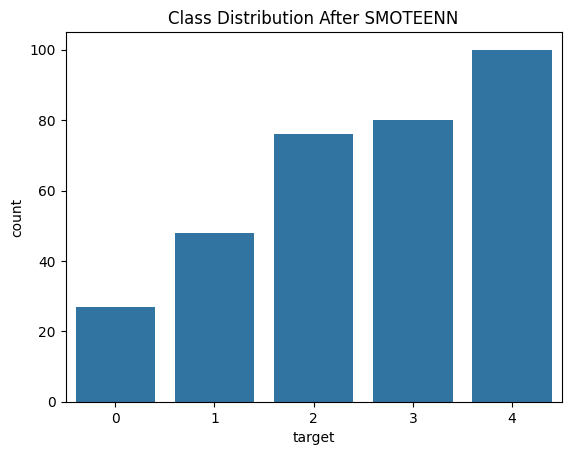

In [22]:
sns.countplot(x=y_res_smoteenn)
plt.title("Class Distribution After SMOTEENN")
plt.show()

In [23]:
# df.rename(columns={'num': 'target'}, inplace=True)

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as skpipeline
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier

# Split data
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

numeric_features = X.columns.tolist()
numeric_transformer = skpipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features)],
    remainder='drop'
)

# # Import from imblearn.pipeline for compatibility with samplers
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTEENN

# Define your pipeline using ImbPipeline

# Define a model to be used in the pipeline
classifier_model = RandomForestClassifier(random_state=42) # Example: using RandomForestClassifier

pipe = ImbPipeline(steps=[
    ('preprocessor', preprocessor),           # Your ColumnTransformer
    ('feature_engineering', PolynomialFeatures(degree=2, include_bias=False)),
    ('balancer', SMOTEENN(random_state=42)),  # ✅ Now allowed
    ('classifier', classifier_model)          # Use the defined classifier object
])

# Fit the pipeline
pipe.fit(X_train, y_train)

# Predict
y_pred = pipe.predict(X_test)

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as skpipeline # Use skpipeline for sklearn's Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline # Use ImbPipeline for imblearn's Pipeline
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import mlflow
import mlflow.sklearn
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier

# Assuming df is loaded and 'target' column is set

# Split data
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

numeric_features = X.columns.tolist()
numeric_transformer = skpipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features)],
    remainder='drop'
)

classic_models = {
    "KNN": KNeighborsClassifier(),
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42)
}

results = {}

# Define the balancing methods
balancing_methods = {
    'SMOTEENN': SMOTEENN(random_state=42)
    # Add other balancing methods here if needed
}

for model_name, model in classic_models.items():
    for bal_name, balancer in balancing_methods.items():
        # Use ImbPipeline instead of sklearn's Pipeline
        pipe = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('feature_engineering', PolynomialFeatures(degree=2, include_bias=False)),
            ('balancer', balancer),
            ('classifier', model)
        ])

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        # Add average='weighted' for multiclass targets
        prec = precision_score(y_test, y_pred, average='weighted')
        # Add average='weighted' for multiclass targets
        rec = recall_score(y_test, y_pred, average='weighted')
        # Add average='weighted' for multiclass targets
        f1 = f1_score(y_test, y_pred, average='weighted')

        results[f"{model_name}_{bal_name}"] = {
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1 Score': f1
        }

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:14:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [26]:
!pip install pycaret

In [27]:
from pycaret.classification import setup, compare_models, pull, save_model

# Setup PyCaret environment using the training data
# PyCaret can handle preprocessing and potentially balancing internally
# If you need to specify balancing, you can explore PyCaret's 'fix_imbalance' parameter in setup
clf = setup(data=pd.concat([X_train, y_train], axis=1), target='target', session_id=42, verbose=False)

# Compare multiple models
best_model = compare_models()

# Get metrics
metrics_df = pull()
print("PyCaret Model Metrics:")
print(metrics_df.head())

# Save best model
save_model(best_model, 'best_pycaret_model')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.6074,0.0000,0.6074,0.5175,0.5490,0.3282,0.3479,0.0330
lda,Linear Discriminant Analysis,0.6007,0.0000,0.6007,0.5633,0.5704,0.3540,0.3640,0.0360
et,Extra Trees Classifier,0.5952,0.5096,0.5952,0.4980,0.5313,0.2992,0.3214,0.1640
rf,Random Forest Classifier,0.5768,0.5114,0.5768,0.4903,0.5110,0.2657,0.2907,0.2090
gbc,Gradient Boosting Classifier,0.5647,0.0000,0.5647,0.5312,0.5373,0.3122,0.3215,0.8630
catboost,CatBoost Classifier,0.5647,0.5426,0.5647,0.4629,0.5027,0.2673,0.2846,11.9110
xgboost,Extreme Gradient Boosting,0.5518,0.5425,0.5518,0.4966,0.5177,0.2796,0.2907,0.3250
lr,Logistic Regression,0.5463,0.0000,0.5463,0.4168,0.4666,0.2002,0.2252,1.1390
qda,Quadratic Discriminant Analysis,0.5397,0.0000,0.5397,0.2917,0.3786,0.0000,0.0000,0.0420
lightgbm,Light Gradient Boosting Machine,0.5397,0.5324,0.5397,0.4900,0.5087,0.2483,0.2559,0.2860


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

PyCaret Model Metrics:
                              Model  Accuracy     AUC  Recall   Prec.      F1  \
ridge              Ridge Classifier    0.6074  0.0000  0.6074  0.5175  0.5490   
lda    Linear Discriminant Analysis    0.6007  0.0000  0.6007  0.5633  0.5704   
et           Extra Trees Classifier    0.5952  0.5096  0.5952  0.4980  0.5313   
rf         Random Forest Classifier    0.5768  0.5114  0.5768  0.4903  0.5110   
gbc    Gradient Boosting Classifier    0.5647  0.0000  0.5647  0.5312  0.5373   

        Kappa     MCC  TT (Sec)  
ridge  0.3282  0.3479     0.033  
lda    0.3540  0.3640     0.036  
et     0.2992  0.3214     0.164  
rf     0.2657  0.2907     0.209  
gbc    0.3122  0.3215     0.863  
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['age', 'sex', 'cp', 'trestbps',
                                              'chol', 'fbs', 'restecg',
                                              'thalach', 'exang', 'oldpeak',
                                              'slope', 'ca', 'thal', 'AD_age',
                                              'AD_trestbps', 'AD_chol',
                                              'AD_thalach', 'AD_oldpeak',
                                              'poly_age', 'poly_trestbps',
                                              'poly_chol', 'poly_thalach',
                                              'poly_oldpeak', 'poly_age^2',
                                              'po...
                                                               missing_values=nan,
                                                        

In [28]:
!pip install pandas scikit-learn imbalanced-learn pycaret tpot h2o mljar-supervised autogluon flaml mlflow

In [29]:
from autogluon.tabular import TabularDataset, TabularPredictor

# Convert to AutoGluon format
train_data = TabularDataset(pd.concat([X_train, y_train], axis=1))
test_data = TabularDataset(X_test)

# Train
predictor = TabularPredictor(label='target').fit(train_data, time_limit=60)

# Evaluate
preds = predictor.predict(test_data)
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=preds, auxiliary_metrics=True)

print("AutoGluon Performance:", perf)
predictor.save("autogluon_heart_model")

No path specified. Models will be saved in: "AutogluonModels/ag-20250519_051931"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
Memory Avail:       10.64 GB / 12.67 GB (83.9%)
Disk Space Avail:   63.74 GB / 107.72 GB (59.2%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competition

AutoGluon Performance: {'accuracy': 0.55, 'balanced_accuracy': 0.2508928571428573, 'mcc': 0.2394294656361803}


In [30]:
from tpot import TPOTClassifier

tpot = TPOTClassifier(generations=5, population_size=20, scoring='accuracy', cv=5, random_state=42, verbosity=2)

tpot.fit(X_train, y_train)
print("TPOT Best Pipeline:", tpot.fitted_pipeline_)

# Evaluate
score = tpot.score(X_test, y_test)
print("TPOT Test Accuracy:", score)
tpot.export("tpot_heart_pipeline.py")

Version 0.12.2 of tpot is outdated. Version 1.0.0 was released Wednesday February 26, 2025.


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.5993794326241135

Generation 2 - Current best internal CV score: 0.5993794326241135

Generation 3 - Current best internal CV score: 0.5993794326241135

Generation 4 - Current best internal CV score: 0.5993794326241135

Generation 5 - Current best internal CV score: 0.5993794326241135

Best pipeline: SGDClassifier(MinMaxScaler(input_matrix), alpha=0.001, eta0=0.1, fit_intercept=False, l1_ratio=0.5, learning_rate=invscaling, loss=hinge, penalty=elasticnet, power_t=0.0)
TPOT Best Pipeline: Pipeline(memory=None,
         steps=[('minmaxscaler',
                 MinMaxScaler(clip=False, copy=True, feature_range=(0, 1))),
                ('sgdclassifier',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.1,
                               fit_intercept=False, l1_ratio=0.5,
                               learning_rate='invscaling', loss='hinge',

In [ ]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()
h2o_df = h2o.H2OFrame(pd.concat([X_train, y_train], axis=1))

# Set up training
x = h2o_df.columns[:-1]
y = h2o_df.columns[-1]

aml = H2OAutoML(max_runtime_secs=120, seed=42)
aml.train(x=x, y=y, training_frame=h2o_df)

# View leaderboard
lb = aml.leaderboard
print("H2O AutoML Leaderboard:")
print(lb.head(rows=lb.nrows))

# Predict
test_h2o = h2o.H2OFrame(X_test)
preds = aml.predict(test_h2o)
aml.leader.download_mojo("h2o_automl_model.zip")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.27" 2025-04-15; OpenJDK Runtime Environment (build 11.0.27+6-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.27+6-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpn33qx244
  JVM stdout: /tmp/tmpn33qx244/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpn33qx244/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,1 month and 21 days
H2O_cluster_name:,H2O_from_python_unknownUser_ep30dj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [35]:
from supervised.automl import AutoML

# Initialize AutoML
mljar = AutoML(
    results_path="mljar_results",
    total_time_limit=120,
    mode="Compete",  # or "Explain", "Perform"

    algorithms=["Xgboost", "Random Forest", "LightGBM"]
)

# Fit
mljar.fit(X_train, y_train)

# Predict
preds = mljar.predict(X_test)

# Score
from sklearn.metrics import accuracy_score
print("MLJAR Accuracy:", accuracy_score(y_test, preds))

This model has already been fitted. You can use predict methods or select a new 'results_path' for a new 'fit()'.
MLJAR Accuracy: 0.6


In [37]:
!pip install pyngrok

In [38]:
from pyngrok import ngrok

# Replace '<your-authtoken>' with your actual token
ngrok.set_auth_token("2xFxwGCmYLD1qlmyuZRacOkUTfL_xJduyAA1wMQSND6C5FgY")

In [39]:
# Step 1: Install dependencies (if not done already)
# !pip install mlflow pyngrok

# Step 2: Load libraries
from pyngrok import ngrok
import subprocess

# Step 3: Set your ngrok authtoken (replace with yours)
ngrok.set_auth_token("2xFxwGCmYLD1qlmyuZRacOkUTfL_xJduyAA1wMQSND6C5FgY")  # ← Replace this!

# Step 4: Start MLflow UI
mlflow_process = subprocess.Popen(["mlflow", "ui", "--port", "9000"])

# Step 5: Create ngrok tunnel
public_url = ngrok.connect(9000)
print(f"MLflow UI is now available at: {public_url}")

MLflow UI is now available at: NgrokTunnel: "https://2c4b-34-41-64-239.ngrok-free.app" -> "http://localhost:9000"


In [43]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
# Assuming you have CatBoost, LGBM, and PyTorch models imported and defined if you want to log them
# from catboost import CatBoostClassifier
# from lightgbm import LGBMClassifier
# import torch
# import torch.nn as nn
# import torch.optim as optim

# Assume y_test is available from previous steps
# Assume X_train, X_test, y_train, y_test are already defined
# Assume preprocessor is defined from previous steps (e.g., ipython-input-34)
# Assume AutoML results and predictors (best_model from pycaret, predictor from autogluon, etc.)
# and their predictions (y_pred_pycaret, autogluon_preds, etc.) are available

# Re-run or ensure previous cells defining X_train, X_test, y_train, y_test, and preprocessor were executed.

# --- Start: Define and Train ClassicML Models and Make Predictions ---
# This section is added to define the classic models and their predictions
# referenced in the logging calls below. Add or modify this section
# based on which models you actually trained and want to log.

# Dictionary to store trained models and their predictions
trained_models = {}
model_predictions = {}

# Example: Train and store a few models from the list in the logging calls
# You need to add code for ALL models you intend to log if they weren't trained already

# Knn_unif
knn_unif = KNeighborsClassifier(weights='uniform')
# Apply preprocessing/balancing if used during training in a pipeline
# For simplicity here, we train on preprocessed data assuming preprocessor is available
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
knn_unif.fit(X_train_processed, y_train)
trained_models['Knn_unif'] = knn_unif
model_predictions['y_pred_knn_unif'] = knn_unif.predict(X_test_processed)
print("Trained Knn_unif and made predictions.")

# Knn_dist (Example)
knn_dist = KNeighborsClassifier(weights='distance')
knn_dist.fit(X_train_processed, y_train) # Using processed data for consistency
trained_models['Knn_dist'] = knn_dist
model_predictions['y_pred_knn_dist'] = knn_dist.predict(X_test_processed)
print("Trained Knn_dist and made predictions.")

# RandomForest_gini (Example)
rf_gini = RandomForestClassifier(criterion='gini', random_state=42)
rf_gini.fit(X_train_processed, y_train)
trained_models['RandomForest_gini'] = rf_gini
model_predictions['y_pred_rf_gini'] = rf_gini.predict(X_test_processed)
print("Trained RandomForest_gini and made predictions.")

# XGBoost (Example)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_processed, y_train)
trained_models['XGBoost'] = xgb
model_predictions['y_pred_xgb'] = xgb.predict(X_test_processed)
print("Trained XGBoost and made predictions.")

# Add code for other models like GradientBoosting, ExtraTreesClassifier, CatBoost, LGBM, NeuralNetTorch
# and store them in trained_models and model_predictions if you want to log them below.
# Example for GradientBoosting:
gbm = GradientBoostingClassifier(random_state=42)
gbm.fit(X_train_processed, y_train)
trained_models['GradientBoosting'] = gbm
model_predictions['y_pred_gbm'] = gbm.predict(X_test_processed)
print("Trained GradientBoosting and made predictions.")


# Ensure the variables referenced in the logging calls exist
# Assign trained models and predictions from the dictionaries if needed
knn_unif = trained_models.get('Knn_unif')
y_pred_knn_unif = model_predictions.get('y_pred_knn_unif')
knn_dist = trained_models.get('Knn_dist')
y_pred_knn_dist = model_predictions.get('y_pred_knn_dist')
rf_gini = trained_models.get('RandomForest_gini')
y_pred_rf_gini = model_predictions.get('y_pred_rf_gini')
# Add assignments for all other models you trained and want to log
gbm = trained_models.get('GradientBoosting')
y_pred_gbm = model_predictions.get('y_pred_gbm')
xgb = trained_models.get('XGBoost')
y_pred_xgb = model_predictions.get('y_pred_xgb')

# --- End: Define and Train ClassicML Models and Make Predictions ---


# Assume AutoML results and predictors (best_model from pycaret, predictor from autogluon, etc.)
# and their predictions (y_pred_pycaret, autogluon_preds, etc.) are available from previous cells.
# Example: Ensure these variables are defined.
# pycaret_model = best_model # Assuming 'best_model' was defined by pycaret.compare_models()
# pycaret_preds = pipe.predict(X_test) # Assuming 'pipe' was the PyCaret model pipeline from setup/compare_models
# If PyCaret output the best model directly, you might need to load it or predict using the loaded model.
# pycaret_model = load_model('best_pycaret_model') # Example if you saved it
# pycaret_preds = pycaret_model.predict(X_test)

# autogluon_predictor = predictor # Assuming 'predictor' was defined by AutoGluon TabularPredictor
# autogluon_preds = predictor.predict(test_data) # Assuming 'test_data' was TabularDataset(X_test)

# tpot_pipeline = tpot.fitted_pipeline_ # Assuming 'tpot' was defined by TPOTClassifier
# tpot_preds = tpot.predict(X_test)

# h2o_model = aml.leader # Assuming 'aml' was defined by H2OAutoML
# h2o_preds = aml.predict(test_h2o).as_data_frame()['predict'] # Assuming 'test_h2o' was H2OFrame(X_test)

# mljar_model = mljar # Assuming 'mljar' was defined by AutoML (MLJAR)
# mljar_preds = mljar.predict(X_test)

# flamls_model = flamls # Assuming 'flamls' was defined by FLAML
# flamls_preds = flamls.predict(X_test)


mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment("Heart Disease Prediction Summary") # New experiment for summary

results = []

def log_model_mlflow(model_name, model, y_true, y_pred, model_type="ClassicML", params=None):
    """Log model performance and metrics in MLflow."""
    # Ensure y_pred is a numpy array or pandas Series for consistent metric calculation
    y_pred = np.asarray(y_pred)

    with mlflow.start_run(run_name=model_name):
        mlflow.log_param("Type", model_type)

        if params:
            mlflow.log_params(params)
        else:
            try:
                # Attempt to log model parameters if get_params is available
                model_params = model.get_params()
                # Filter out non-serializable parameters if necessary
                serializable_params = {k: v for k, v in model_params.items() if isinstance(v, (int, float, str, bool, list, dict, tuple, type(None)))}
                mlflow.log_params(serializable_params)
            except:
                 mlflow.log_param("params_available", "No")
                 # Log a placeholder or message if get_params fails
                 mlflow.log_param("params_logging_failed", "Could not retrieve or log model parameters.")


        acc = accuracy_score(y_true, y_pred)
        # Use zero_division=0 to avoid warnings if a class has no predicted samples
        prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

        mlflow.log_metrics({
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1 Score": f1
        })

        try:
            # Log the model itself if it's a scikit-learn compatible model
            if model_type == "ClassicML" or isinstance(model, (RandomForestClassifier, KNeighborsClassifier, XGBClassifier, GradientBoostingClassifier, ExtraTreesClassifier)):
                 mlflow.sklearn.log_model(model, "model") # Use a generic artifact path like "model"
            elif model_type == "AutoML" and hasattr(model, 'save'):
                 # For AutoML libraries that have a save method (like AutoGluon)
                 model_save_path = f"./{model_name}_saved_model"
                 model.save(model_save_path)
                 mlflow.log_artifact(model_save_path, "model")
            # Add more specific logging for other AutoML libraries if needed
        except Exception as e:
            print(f"Could not log model artifact for {model_name}: {e}")
            mlflow.log_param("model_logging_failed", str(e))


        print(f"{model_name} - Accuracy: {acc:.4f}, F1 Score: {f1:.4f}, Run ID: {mlflow.active_run().info.run_id}")
        return {
            'Model': model_name,
            'Type': model_type,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1 Score': f1,
            'Run ID': mlflow.active_run().info.run_id # Include Run ID in the results
        }

# -------------------------------
# ClassicML Models (Log the models and predictions you trained above)
# Add calls here for ALL classic models you trained and want to log
# Ensure the model objects (e.g., knn_unif) and prediction variables (e.g., y_pred_knn_unif) exist
# -------------------------------

if 'knn_unif' in trained_models and 'y_pred_knn_unif' in model_predictions:
    results.append(log_model_mlflow("Knn_unif", knn_unif, y_test, y_pred_knn_unif, model_type="ClassicML"))
if 'knn_dist' in trained_models and 'y_pred_knn_dist' in model_predictions:
    results.append(log_model_mlflow("Knn_dist", knn_dist, y_test, y_pred_knn_dist, model_type="ClassicML"))
if 'RandomForest_gini' in trained_models and 'y_pred_rf_gini' in model_predictions:
    results.append(log_model_mlflow("RandomForest_gini", rf_gini, y_test, y_pred_rf_gini, model_type="ClassicML"))
# Add checks and calls for other classic models if trained
# if 'RandomForest_ent' in trained_models and 'y_pred_rf_entropy' in model_predictions:
#     results.append(log_model_mlflow("RandomForest_ent", rf_entropy, y_test, y_pred_rf_entropy, model_type="ClassicML"))
# if 'ExtraTree_gini' in trained_models and 'y_pred_et_gini' in model_predictions:
#     results.append(log_model_mlflow("ExtraTree_gini", et_gini, y_test, y_pred_et_gini, model_type="ClassicML"))
# if 'ExtraTree_ent' in trained_models and 'y_pred_et_entropy' in model_predictions:
#     results.append(log_model_mlflow("ExtraTree_ent", et_entropy, y_test, y_pred_et_entropy, model_type="ClassicML"))
if 'GradientBoosting' in trained_models and 'y_pred_gbm' in model_predictions:
     results.append(log_model_mlflow("GradientBoosting", gbm, y_test, y_pred_gbm, model_type="ClassicML"))
if 'XGBoost' in trained_models and 'y_pred_xgb' in model_predictions:
     results.append(log_model_mlflow("XGBoost", xgb, y_test, y_pred_xgb, model_type="ClassicML"))
# if 'CatBoost' in trained_models and 'y_pred_catboost' in model_predictions:
#      results.append(log_model_mlflow("CatBoost", catboost, y_test, y_pred_catboost, model_type="ClassicML"))
# if 'LGBM' in trained_models and 'y_pred_lgbm' in model_predictions:
#      results.append(log_model_mlflow("LGBM", lgbm, y_test, y_pred_lgbm, model_type="ClassicML"))
# if 'NeuralNetTorch' in trained_models and 'y_pred_torch' in model_predictions:
#      results.append(log_model_mlflow("NeuralNetTorch", torch_model, y_test, y_pred_torch, model_type="ClassicML"))


# -------------------------------
# AutoML Models (Log results from previously run AutoML libraries)
# Ensure the model/predictor objects and prediction variables exist from previous cells.
# -------------------------------

# Example: Check if PyCaret results are available
# You might need to retrieve the best model and make predictions if not done already after compare_models()
try:
    # Assuming 'best_model' from pycaret.compare_models() is the object
    # And you have a way to get predictions from it, e.g., using the trained pipeline
    if 'pipe' in locals() and hasattr(pipe, 'predict') and 'y_test' in locals():
        pycaret_preds = pipe.predict(X_test)
        # Use the trained pipeline object itself if it's logging compatible, or the final classifier step
        pycaret_model_obj = pipe # Or pipe.named_steps['classifier'] if just logging the model
        results.append(log_model_mlflow("PyCaret_BestModel", pycaret_model_obj, y_test, pycaret_preds, model_type="AutoML"))
    elif 'best_pycaret_model' in locals(): # If you saved and loaded the model
         # Load the saved model to make predictions if needed
         # from pycaret.classification import load_model as load_pycaret_model
         # loaded_pycaret_model = load_pycaret_model('best_pycaret_model')
         # pycaret_preds = loaded_pycaret_model.predict(X_test)
         print("PyCaret model object or predictions not readily available for logging.")
    else:
        print("PyCaret results not available for logging.")
except NameError:
    print("PyCaret variables not defined for logging.")


# Example: Check if AutoGluon results are available
try:
    if 'predictor' in locals() and hasattr(predictor, 'predict') and 'test_data' in locals() and 'y_test' in locals():
        autogluon_preds = predictor.predict(test_data)
        results.append(log_model_mlflow("AutoGluon_BestPredictor", predictor, y_test, autogluon_preds, model_type="AutoML"))
    else:
        print("AutoGluon results not available for logging.")
except NameError:
     print("AutoGluon variables not defined for logging.")


# Example: Check if TPOT results are available
try:
    if 'tpot' in locals() and hasattr(tpot, 'predict') and hasattr(tpot, 'fitted_pipeline_') and 'X_test' in locals() and 'y_test' in locals():
         tpot_preds = tpot.predict(X_test)
         results.append(log_model_mlflow("TPOT_BestPipeline", tpot.fitted_pipeline_, y_test, tpot_preds, model_type="AutoML"))
    else:
        print("TPOT results not available for logging.")
except NameError:
    print("TPOT variables not defined for logging.")


# Example: Check if H2O AutoML results are available
try:
    if 'aml' in locals() and hasattr(aml, 'leader') and hasattr(aml, 'predict') and 'test_h2o' in locals() and 'y_test' in locals():
        # H2O predictions are typically H2OFrame, convert to pandas/numpy
        h2o_preds_h2oframe = aml.predict(test_h2o)
        h2o_preds = h2o_preds_h2oframe.as_data_frame()['predict'] # Get the prediction column
        results.append(log_model_mlflow("H2OAutoML_BestModel", aml.leader, y_test, h2o_preds, model_type="AutoML"))
    else:
         print("H2O AutoML results not available for logging.")
except NameError:
    print("H2O AutoML variables not defined for logging.")
except Exception as e: # Catch potential errors during H2O prediction/conversion
    print(f"Error processing H2O AutoML results: {e}")


# Example: Check if MLJAR results are available
try:
    if 'mljar' in locals() and hasattr(mljar, 'predict') and 'X_test' in locals() and 'y_test' in locals():
        mljar_preds = mljar.predict(X_test)
        results.append(log_model_mlflow("MLJAR_BestModel", mljar, y_test, mljar_preds, model_type="AutoML"))
    else:
         print("MLJAR results not available for logging.")
except NameError:
    print("MLJAR variables not defined for logging.")


# Example: Check if FLAML results are available
# You will need to define and train a FLAML model elsewhere if you want to log it
try:
    if 'flamls' in locals() and hasattr(flamls, 'predict') and 'X_test' in locals() and 'y_test' in locals():
        flamls_preds = flamls.predict(X_test)
        results.append(log_model_mlflow("FlaML_AutoML", flamls, y_test, flamls_preds, model_type="AutoML"))
    else:
         print("FLAML results not available for logging.")
except NameError:
    print("FLAML variables not defined for logging.")


# -------------------------------
# Convert to DataFrame and Display
# -------------------------------

if results: # Only proceed if there are results to display
    results_df = pd.DataFrame(results)

    # Sort by F1 Score (descending)
    results_df = results_df.sort_values(by="F1 Score", ascending=False).reset_index(drop=True)

    print("\nTop Performing Models:")
    print(results_df) # Print the full DataFrame

    # -------------------------------
    # Save to CSV
    # -------------------------------

    results_df.to_csv("heart_disease_all_model_results.csv", index=False)
    print("\nResults saved to 'heart_disease_all_model_results.csv'")
else:
    print("\nNo model results were logged.")

Trained Knn_unif and made predictions.
Trained Knn_dist and made predictions.
Trained RandomForest_gini and made predictions.
Trained XGBoost and made predictions.


2025/05/19 05:49:33 INFO mlflow.tracking.fluent: Experiment with name 'Heart Disease Prediction Summary' does not exist. Creating a new experiment.


Trained GradientBoosting and made predictions.


2025/05/19 05:49:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RandomForest_gini - Accuracy: 0.5667, F1 Score: 0.5188, Run ID: 22822998e70949a0b29240d83bb8bdb9


2025/05/19 05:49:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


GradientBoosting - Accuracy: 0.5333, F1 Score: 0.4941, Run ID: 0b2d3a2cb004452592480a54069b4cf4


2025/05/19 05:49:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBoost - Accuracy: 0.5333, F1 Score: 0.5185, Run ID: 78e3254cad724201a85ca857aab3fe2a
PyCaret_BestModel - Accuracy: 0.3000, F1 Score: 0.3340, Run ID: 5f684a7d6b464c6d90a9803b5c2e94ec
Could not log model artifact for AutoGluon_BestPredictor: [Errno 2] No such file or directory: './AutoGluon_BestPredictor_saved_model'
AutoGluon_BestPredictor - Accuracy: 0.5500, F1 Score: 0.4827, Run ID: 66b204e9f3ff4497959882fa0eb82d35
TPOT_BestPipeline - Accuracy: 0.6333, F1 Score: 0.5981, Run ID: c3f7d46580ea47aab1546f35532fe34e
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Error processing H2O AutoML results: Classification metrics can't handle a mix of multiclass and continuous targets


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)



MLJAR_BestModel - Accuracy: 0.6000, F1 Score: 0.5502, Run ID: 276d5b9a02554792bea5d0f3f8d6fa0f
FLAML results not available for logging.

Top Performing Models:
                     Model       Type  Accuracy  Precision    Recall  \
0        TPOT_BestPipeline     AutoML  0.633333   0.599498  0.633333   
1          MLJAR_BestModel     AutoML  0.600000   0.519231  0.600000   
2        RandomForest_gini  ClassicML  0.566667   0.488889  0.566667   
3                  XGBoost  ClassicML  0.533333   0.505859  0.533333   
4         GradientBoosting  ClassicML  0.533333   0.460326  0.533333   
5  AutoGluon_BestPredictor     AutoML  0.550000   0.432540  0.550000   
6        PyCaret_BestModel     AutoML  0.300000   0.440568  0.300000   

   F1 Score                            Run ID  
0  0.598116  c3f7d46580ea47aab1546f35532fe34e  
1  0.550172  276d5b9a02554792bea5d0f3f8d6fa0f  
2  0.518753  22822998e70949a0b29240d83bb8bdb9  
3  0.518462  78e3254cad724201a85ca857aab3fe2a  
4  0.494143  0b2d3a2cb0